<a href="https://colab.research.google.com/github/clemencia/ML4PPGF_UERJ/blob/master/Medidas_de_Performance_Avaliacao_Modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ROC: Avaliação de Classificadores Binários

Em problemas de classificação binária (distinguir sinal de ruído)  a medida de performance frequentemente é a **acurácia**, porém as vezes uma alta acurácia vem a um custo  de **ineficiência**. Por isso em casos de classificadores como BDT vimos as curvas PRC que indicavam como muda a **precisão** (ou **pureza**)  e o ***recall*** ou **eficiência** ao mudarmos o critério de corte.

---

### A curva ROC
A sigla ROC vem de ***receiving operator characteristic***, pois foi ideado originalmente para detectar objetos em radares, ou também ***relative operator characteristic*** pois relaciona duas caraterísticas do "operador", a precisão e a eficiência.

Primeiro devemos esclarecer as definições dos conceitos acima. Vamos ter em mente a *matriz confusão*:


|*Resposta*| Sinal | Ruido | ***Total*** |
|----------| ------|------ |-------------|
|*Negativo*|  <font color=red >$F_N$ </font>| <font color=green> $V_N$</font> |         $N$ |
|*Positivo*| <font color=green >$V_P$</font> | <font color=red> $F_P$</font>  |        $P$ |
|**Total** | $$S$$   |  $$B $$  |  $$T = N+P = S+B$$  |


Onde a soma das linhas:
 $$ P = V_P + F_P  \;\;\; \mathrm{e} \;\;\; N = F_N + V_N $$
e a soma das colunas:
 $$ S = V_P + F_N  \;\;\; \mathrm{e} \;\;\; B = V_N + F_P $$

---

### Definições : 
   * **Acurácia**: fração das instâncias classificadas corretamente (seja como sinal ou background)
$$ a = \dfrac{V_P + V_N}{T} $$
   * **Precisão**: fração das instâncias classificadas como positivas que são sinal verdadeiro (i.e. estão corretas). Também chamada de *pureza*.
   $$ p = \dfrac{V_P}{P}$$
   * **Eficiência**: fração do sinal que foi corretamente classificado de forma positiva. Também chamado de *recall* ou **TPR** (*true positive rate*).
   $$ \epsilon = \dfrac{V_P}{S}$$
   * **Especificidade**: fração de background corretamente classificado de forma negativa, também conhecido de  **TNR** (*true negative rate*) e seria equivalente à eficiência em identificar o ruído (aka *background rejection*)
   $$ \epsilon_{B} = \dfrac{V_N}{B} $$  
   * ***False Positive Rate***: (**FPR**) é a fração das instâncias de background classificadas incorretamente de forma positiva.
   $$ f_{FP} = \dfrac{F_P}{B} = 1-\epsilon_B$$
   * ***False Negative Rate***: (**FNR**) é a fração das instâncias de sinal classificadas incorretamente de forma negativa, i.e. a *ineficiência*.
   $$ f_{FN} = \dfrac{F_N}{S} = 1 - \epsilon$$ 

---

Nas curvas ROC geralmente  é graficado no eixo $y$ a eficiência (aka recall ou TPR) que queremos ser o máximo possível e no eixo $x$ o FPR ($f_{FP}$ que é  $1 -$ TNR) que deveria ser pequeno.

Porém quando nosso sinal é raro ou estamos mais preocupados dos falsos positivos que dos falsos negativos é preferível usar a curva chamada *PR* (*precision-recall*, ou seja pureza vs eficiência) 


Em medicina pode ser mais importante conhecer e optimizar em função da especificidade (excepto em epidemias ou doenças muito raras), mas em física de altas energias por exemplo ela é irrelevante. 

Específicamente para medicina também é importante conhecer a ***prevalência*** de um sinal  (ou doença), quer dizer quão frequênte ela é na população.

$$ \pi_s = \dfrac{S}{T}$$

### Exemplo: Classificação binaria de um dígito 

Quer dizer, queremos que nosso classificador decida se é ou não um número 5, por exemplo.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [2]:
X, y = mnist["data"], mnist["target"]
print(X.shape,y.shape)

(70000, 784) (70000,)


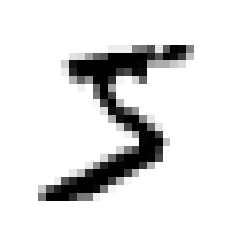

5


In [3]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")
plt.show()
print(y[0])

In [0]:
#algumas definições úteis
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")


def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

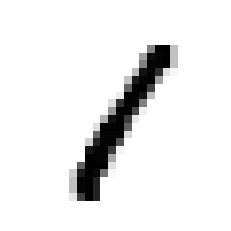

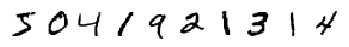

In [5]:
plot_digit(X[3])
plt.show()
plot_digits(X[0:10])

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=10000,random_state=42)

Agora redefinimos o alvo ($y$) para ter um resultado binário: Sim ou Não (ou *verdadeiro ou falso*). O sinal (ou Sim) é o dígito 5.

In [0]:
y_train_5 = (y_train == '5')
y_test_5  = (y_test == '5')


Chamamos agora um modelo de ***Stochastic Gradient Descent*** para classificar os dados. Por default é um SVM,  [vide documentação](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier)

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

[ True]


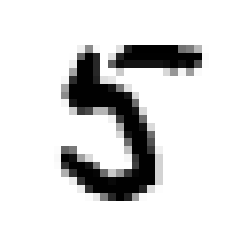

[False]


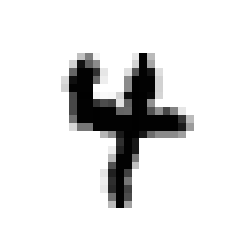

In [9]:
print(sgd_clf.predict([X_test[15]]))
plot_digit(X_test[15])
plt.show()
print(sgd_clf.predict([X_test[1]]))
plot_digit(X_test[1])
plt.show()

In [0]:
y_predict_5 = sgd_clf.predict(X_test)

Agora podemos testar a acurácia do modelo com cross-validation, nesse caso com 3 sub-conjuntos aleatórios dos dados de treinamento, e também a validação do conjunto de teste.

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,precision_score,recall_score

print(cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring="accuracy"))


[0.9629  0.96775 0.96435]


In [12]:
print("acuracia = {:2.3f} ".format(accuracy_score(y_test_5,y_predict_5)))
print("precisao = {:2.3f} e eficiencia = {:2.3f}".format(precision_score(y_test_5,y_predict_5),recall_score(y_test_5,y_predict_5)))

acuracia = 0.966 
precisao = 0.853 e eficiencia = 0.767


Para comparação, podemos criar um classificador que nunca responde sim. A classe não faz nada no fit  e na predição vai dar sempre a resposta negativa. Qual será a acurácia desse classificador?

In [0]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

Chamaos a validação do modelo e tanto na cross-validation como na validação no teste da uma acurácia de ~90%

In [14]:
never_5_clf = Never5Classifier()
print(cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy"))
y_pred_never_5=never_5_clf.predict(X_test)
print(accuracy_score(y_test_5,y_pred_never_5))

[0.9119  0.90875 0.91055]
0.9063


Mas se pesquisamos a precisão e eficiência, elas são zero (ou seja todas as instâncias negativas são classificadas corretamente, mas nenhuma das instâncias positivas)

In [15]:
print(precision_score(y_test_5,y_pred_never_5),recall_score(y_test_5,y_pred_never_5))


0.0 0.0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Recapitulando, a predição de "chutar" todas as predições como não sendo o dígito 5 dá certo ~90% do tempo pois ~1/10 dos dígitos nos dados são 5, então reflete a *prevalência* do sinal. Mas se examinarmos a precisão (pureza) e a eficiência (*recall*) vemos que esse mêtodo não tem boa performance.


## Matriz confusão com o SciKit Learn


In [0]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)


In [0]:
y_train_predallzero = never_5_clf.predict(X_train)
y_train_predperfect = y_train_5 

In [18]:
from sklearn.metrics import confusion_matrix
print("Test sample confusion matrix")
print(confusion_matrix(y_test_5,y_predict_5))
print("\n")
print("Training sample confusion matrix")
print(confusion_matrix(y_train_5, y_train_pred))

Test sample confusion matrix
[[8939  124]
 [ 218  719]]


Training sample confusion matrix
[[54103   521]
 [ 1579  3797]]


In [19]:
print("Perfect score confusion matrix")
print(confusion_matrix(y_train_5, y_train_predperfect))

Perfect score confusion matrix
[[54624     0]
 [    0  5376]]


In [20]:
print("Never 5 confusion matrix")
print(confusion_matrix(y_train_5, y_train_predallzero))

Never 5 confusion matrix
[[54624     0]
 [ 5376     0]]


O resultado do valor da precisão e da eficiência para o modelo SGD é

In [21]:
print("precision {:2.1f}%".format(100*precision_score(y_train_5, y_train_pred)))
print("recall {:2.1f}%".format(100*recall_score(y_train_5,y_train_pred)))

precision 87.9%
recall 70.6%


Para acessar os valores da função de decisão:

In [22]:
y_scores = sgd_clf.decision_function(X_train)
y_scores[0]

-14144.506062058408

A função `precision_recall_curve` retorna os valores de pureza e eficiência do método a medida que muda o *threshold* da decisão

In [0]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Podemos salvar o ponto limite onde a precisão/pureza alcança 90%. Neste ponto, quanto é o valor da eficiência?

In [24]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
print(threshold_90_precision)

recall_90_precision = recalls[np.argmax(precisions>=0.9)]
print(recall_90_precision)

483.1147511086346
0.7345610119047619


A função definida embaixo ajuda a fazer o gráfico da evolução da pureza e recall com o valor do *threshold* de desição. O *threshold* de 90% de pureza está indicado em vermelho.

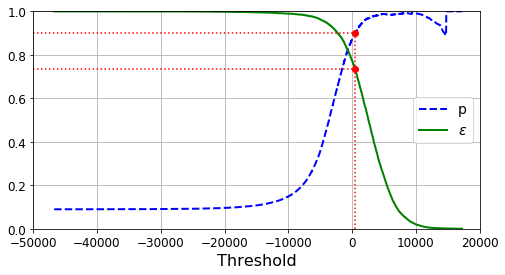

In [25]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="p", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="$\epsilon$", linewidth=2)
    plt.legend(loc="center right", fontsize=14) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 20000, 0, 1])             # Not shown

plt.figure(figsize=(8, 4))                      # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")         # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")      # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                   # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")               
plt.show()

A curva PRC então pode ser graficada a a seguir

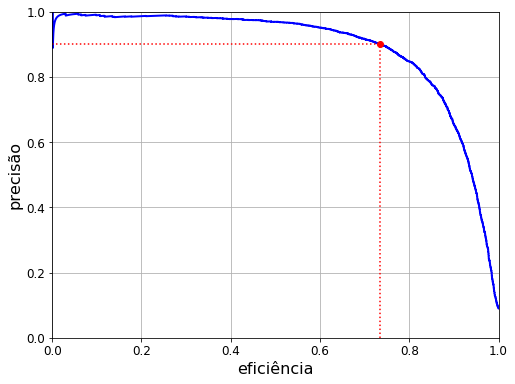

In [26]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("eficiência", fontsize=16)
    plt.ylabel("precisão", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

In [27]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
print(precision_score(y_train_5,y_train_pred_90))
print(accuracy_score(y_train_5,y_train_pred_90))
rec_point = recall_score(y_train_5,y_train_pred_90)
print("{:2.4e}".format(rec_point))


0.900159562343287
0.9689166666666666
7.3456e-01


A curva ROC relaciona outras métricas: o *false positive rate* e o *true positive rate* (recall).

In [0]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [29]:
fpr_point = fpr[np.argmax(thresholds<=threshold_90_precision)]
print("{:2.4e}".format(fpr_point))



8.0368e-03


No gráfico o ponto de 90% de pureza tem 0.8% de taxa de falsos negativos.

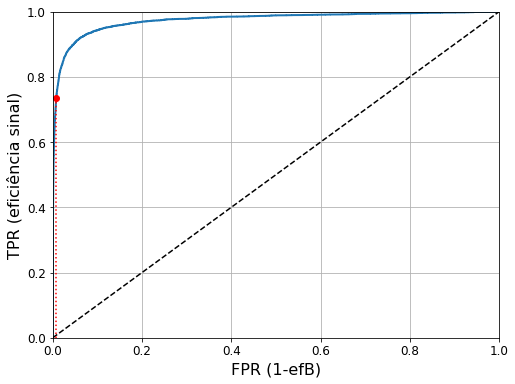

In [30]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('FPR (1-efB)', fontsize=16) # Not shown
    plt.ylabel('TPR (eficiência sinal)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([fpr_point, fpr_point], [0., rec_point], "r:") # Not shown
plt.plot([0.0, fpr_point], [rec_point, rec_point], "r:")  # Not shown
plt.plot([fpr_point], [rec_point], "ro")               # Not shown
                        # Not shown
plt.show()

Um possível índice de performance é a área sob a curva ROC (AUC)

In [31]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)


0.9741394824488451

Agora podemos comparar com um modelo de **RandomForest**

In [0]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [0]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)
prec_forest, rec_forest, threshs_frst = precision_recall_curve(y_train_5, y_scores_forest)

In [34]:
thr_frst_90 = threshs_frst[np.argmax(prec_forest>=0.9)]
print(thr_frst_90)
y_pred_frst_90 = (y_scores_forest >= thr_frst_90) 
rec_pnt_frst = rec_forest[np.argmax(y_pred_frst_90)]
fpr_pnt_frst = fpr_forest[np.argmax(y_pred_frst_90)]
print(rec_pnt_frst,fpr_pnt_frst)

0.24
0.9696800595238095 7.322788517867604e-05


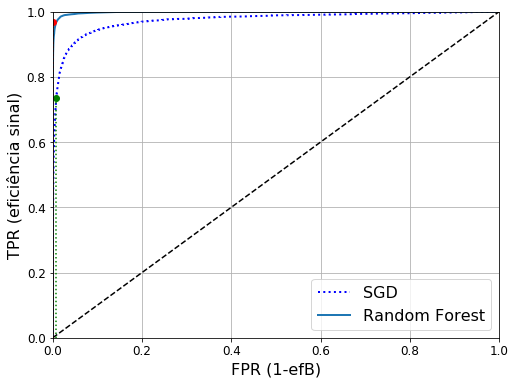

In [35]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_point, fpr_point], [0., rec_point], "g:")
plt.plot([0.0, fpr_point], [rec_point, rec_point], "g:")
plt.plot([fpr_point], [rec_point], "go")
plt.plot([fpr_pnt_frst, fpr_pnt_frst], [0., rec_pnt_frst], "r:")
plt.plot([fpr_pnt_frst], [rec_pnt_frst], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [36]:
roc_auc_score(y_train_5, y_scores_forest)

0.9984563317302746

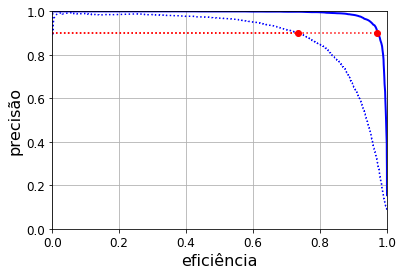

In [37]:
plt.plot(recalls,precisions,"b:")
plot_precision_vs_recall(prec_forest,rec_forest)
plt.plot([0,rec_point],[0.9,0.9],"r:")
plt.plot([rec_point],[0.9],"ro")
plt.plot([0,rec_pnt_frst],[0.9,0.9],"r:")
plt.plot([rec_pnt_frst],[0.9],"ro")
plt.show()

In [38]:
from sklearn.metrics import f1_score

print(f1_score(y_train_5, y_train_pred_90))
print(f1_score(y_train_5, y_pred_frst_90))

0.808972651848817
0.9381452554089236


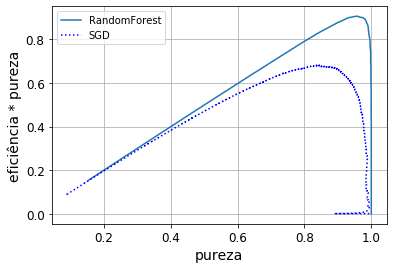

In [60]:
plt.plot(prec_forest,prec_forest*rec_forest,label="RandomForest")
plt.plot(precisions,precisions*recalls,"b:",label="SGD")
plt.grid(True) 
plt.xlabel("pureza")
plt.ylabel("eficiência * pureza")
plt.legend(loc="upper left")
plt.show()

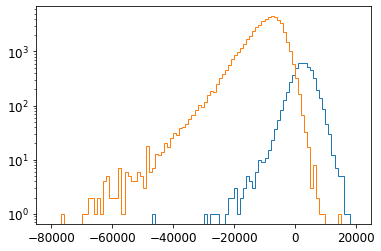

In [40]:
y_scores_only_signals = y_scores[y_train_5]
y_scores_only_backg = y_scores[~y_train_5]
#h = np.histogram(y_scores_only_signals,bins=100,range(0,1000))
plt.hist(y_scores_only_signals,bins=100,range=(-80000,20000),histtype="step")
plt.hist(y_scores_only_backg,bins=100,range=(-80000,20000),histtype="step")
plt.yscale("log")
plt.show()

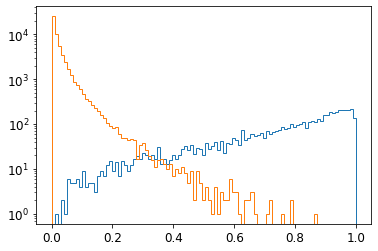

In [41]:
y_scores_only_signals_frst = y_scores_forest[y_train_5]
y_scores_only_backg_frst = y_scores_forest[~y_train_5]
#h = np.histogram(y_scores_only_signals,bins=100,range(0,1000))
plt.hist(y_scores_only_signals_frst,bins=101,range=(0.,1.),histtype="step")
plt.hist(y_scores_only_backg_frst,bins=101,range=(0.,1.),histtype="step")
plt.yscale("log")
plt.show()

### Amostra "reduzida" (só 3 números)

Aqui a prevalencia do "sinal"  (número 5) aumenta de 1/10 a 1/3. 

In [42]:
indx = [i for i,y in enumerate(y_train) if y in ["3","5","8"]]
X_train_reduced = X_train[ indx]
y_train_5_reduced = y_train_5[indx]
print(X_train.shape)
print(X_train_reduced.shape)


(60000, 784)
(17339, 784)


In [0]:
forest_redx_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest_reduced = cross_val_predict(forest_redx_clf, X_train_reduced, y_train_5_reduced, cv=3,
                                    method="predict_proba")

In [0]:
y_scores_frst_redx = y_probas_forest_reduced[:, 1] # score = proba of positive class
fpr_frst_rdx, tpr_frst_rdx, thresholds_frst_redx = roc_curve(y_train_5_reduced,y_scores_frst_redx)
prec_frst_rdx, rec_frst_rdx, threshs_frst_redx = precision_recall_curve(y_train_5_reduced, y_scores_frst_redx)

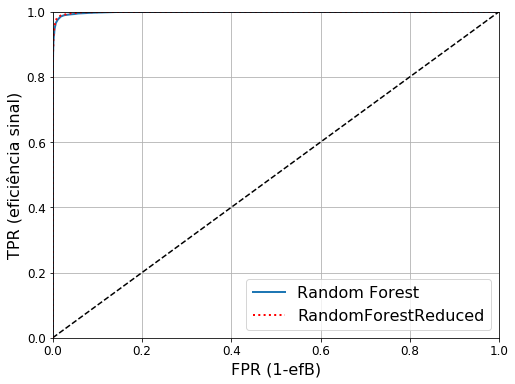

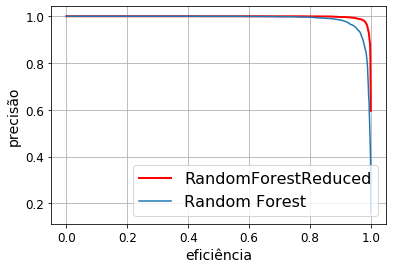

In [61]:
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot(fpr_frst_rdx, tpr_frst_rdx, "r:", linewidth=2, label="RandomForestReduced")

plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

plt.plot(rec_frst_rdx,prec_frst_rdx,"r",linewidth=2,label="RandomForestReduced")
plt.plot(rec_forest,prec_forest,label="Random Forest")
plt.xlabel("eficiência")
plt.ylabel("precisão")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

Nos gráficos acima podemos ver que na amostra reduzida a curva ROC não muda, mas a curva PRC mostra uma melhoria.

![texto alternativo](https://github.com/clemencia/ML4PPGF_UERJ/blob/master/pics/Thresh_vary_valassi.png?raw=true)

![texto](https://github.com/clemencia/ML4PPGF_UERJ/blob/master/pics/ROC_PRC_prevalence.png?raw=true)

![texto](https://github.com/clemencia/ML4PPGF_UERJ/blob/master/pics/TableDomains.png?raw=true)

Podemos testar para o modelo MLP


In [46]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.datasets import mnist
from keras.utils import np_utils

# Trainign batch size 
batch_size = 64
# Number of training epochs
epochs = 20
# Fraction of the training data to be used as validation
val_split = 0.3

# Learning rate
lr=0.1

X_train_mlp = X_train.astype('float32')
X_test_mlp = X_test.astype('float32')
X_train_mlp /= 255
X_test_mlp /= 255


Using TensorFlow backend.


In [47]:
# Multilayer Perceptron model
model = Sequential()
model.add(Dense(input_dim=784, activation="relu", units=100, kernel_initializer="normal"))
model.add(Dense(activation="relu", units=30, kernel_initializer="normal")) # after first layer no need to specify input_dim
model.add(Dense(activation="relu", units=10, kernel_initializer="normal")) # after first layer no need to specify input_dim
model.add(Dense(activation="sigmoid", units=1, kernel_initializer="normal"))
model.compile(optimizer=SGD(lr=lr), loss='mean_squared_error', metrics=['accuracy'])
model.summary()





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3030      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                310       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 81,851
Trainable params: 81,851
Non-trainable params: 0
_________________________________________________________________


In [48]:
history = model.fit(X_train_mlp, y_train_5, validation_split=val_split, epochs=epochs, batch_size=batch_size, verbose=1)




Train on 42000 samples, validate on 18000 samples
Epoch 1/20





42000/42000 [==============================] - 3s 77us/step - loss: 0.0949 - acc: 0.9096 - val_loss: 0.0825 - val_acc: 0.9094
Epoch 2/20
42000/42000 [==============================] - 2s 51us/step - loss: 0.0809 - acc: 0.9108 - val_loss: 0.0817 - val_acc: 0.9094
Epoch 3/20
42000/42000 [==============================] - 2s 54us/step - loss: 0.0796 - acc: 0.9108 - val_loss: 0.0790 - val_acc: 0.9094
Epoch 4/20
42000/42000 [==============================] - 2s 51us/step - loss: 0.0736 - acc: 0.9108 - val_loss: 0.0692 - val_acc: 0.9094
Epoch 5/20
42000/42000 [==============================] - 2s 53us/step - loss: 0.0519 - acc: 0.9257 - val_loss: 0.0301 - val_acc: 0.9628
Epoch 6/20
42000/42000 [==============================] - 2s 52us/step - loss: 0.0220 - acc: 0.9736 - val_loss: 0.0180 - val_acc: 0.9783
Epoch 7/20
42000/42000 [==============================] - 2s 53us/step - loss: 0.0143 - acc: 0.9824 - val_loss: 0.0135 -

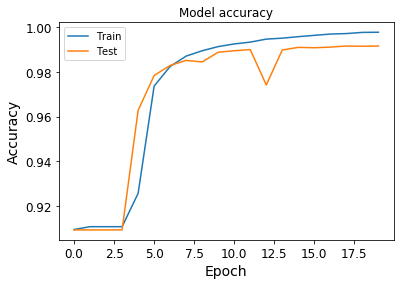

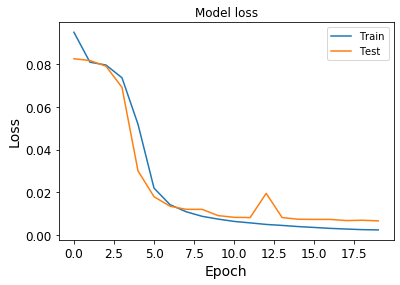

In [49]:
# Training History Visualization
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [0]:
y_predtest_mlp = model.predict(X_test_mlp)

In [0]:
y_pred_mlp = model.predict(X_train_mlp)
prec_mlp, rec_mlp, thresh_mlp = precision_recall_curve(y_train_5, y_pred_mlp)

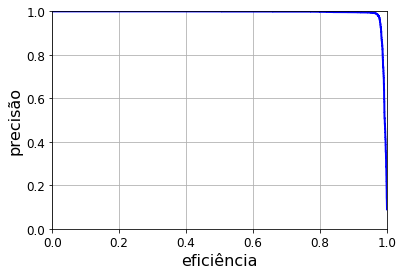

In [52]:
plot_precision_vs_recall(prec_mlp,rec_mlp)


In [0]:
fpr_mlp, tpr_mlp, threshs_mlp = roc_curve(y_train_5, y_pred_mlp)

0.99770487755197

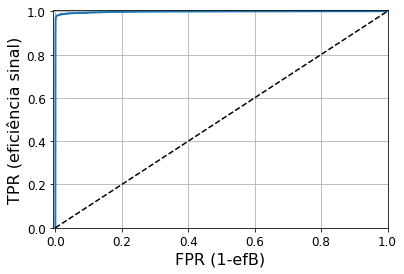

In [54]:
plot_roc_curve(fpr_mlp,tpr_mlp)
plt.axis([-0.008,1,0.0,1.004])

roc_auc_score(y_train_5,y_pred_mlp)

In [55]:
roc_auc_score(y_test_5,y_predtest_mlp)

0.9976309554216182

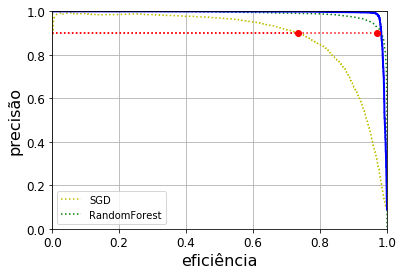

In [56]:
plt.plot(recalls,precisions,"y:",label="SGD")
plt.plot(prec_forest,rec_forest,"g:",label="RandomForest")
plot_precision_vs_recall(prec_mlp,rec_mlp)
plt.plot([0,rec_point],[0.9,0.9],"r:")
plt.plot([rec_point],[0.9],"ro")
plt.plot([0,rec_pnt_frst],[0.9,0.9],"r:")
plt.plot([rec_pnt_frst],[0.9],"ro")
plt.legend(loc="lower left")

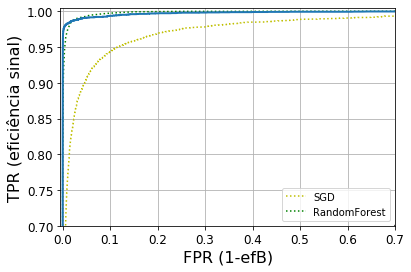

In [57]:
plt.plot(fpr,tpr,"y:",label="SGD")
plt.plot(fpr_forest,tpr_forest,"g:",label="RandomForest")
plot_roc_curve(fpr_mlp,tpr_mlp)
plt.axis([-0.005,0.7,0.7,1.004])

plt.legend(loc="lower right")

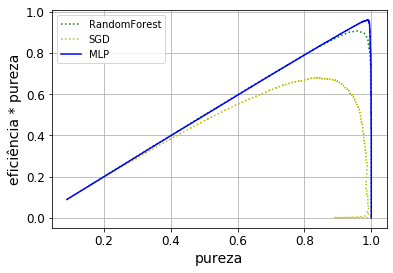

In [62]:
plt.plot(prec_forest,prec_forest*rec_forest,"g:",label="RandomForest")
plt.plot(precisions,precisions*recalls,"y:",label="SGD")
plt.plot(prec_mlp,rec_mlp*prec_mlp,"blue",label="MLP")
plt.grid(True) 
plt.xlabel("pureza")
plt.ylabel("eficiência * pureza")
plt.legend(loc="upper left")
plt.show()

Para achar o ponto com o melhor valor de threshold:

Melhor Eficiencia:  0.9681919642857143  Melhor precisão:  0.9897318881916715
Melhor valor do threshold:  0.5188121


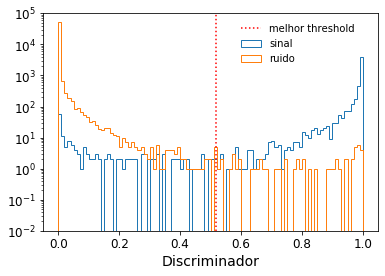

In [114]:
idxmaxeffpur = np.argmax(prec_mlp*rec_mlp)
#effpurmax = np.max(prec_mlp*rec_mlp)
#print(effpurmax,idxmaxeffpur)
print("Melhor Eficiencia: ",rec_mlp[idxmaxeffpur]," Melhor precisão: ",prec_mlp[idxmaxeffpur])
best_thresh_mlp=thresh_mlp[np.argmax(prec_mlp>=prec_mlp[idxmaxeffpur])]
print("Melhor valor do threshold: ",best_thresh_mlp)
y_pred_mlp_best = (y_pred_mlp>= best_thresh_mlp)
f1_score(y_train_5,y_pred_mlp_best)
plt.hist(y_pred_mlp[y_train_5] ,bins=100,range=(0,1),histtype='step',label="sinal")
plt.hist(y_pred_mlp[~y_train_5],bins=100,range=(0,1),histtype='step',label="ruido")
plt.plot([best_thresh_mlp,best_thresh_mlp],[0.01,1e5],"r:",label="melhor threshold")
plt.axis([-0.05,1.05,0.01,1e5])
plt.yscale("log")
plt.xlabel("Discriminador")
plt.legend(loc=(0.58,0.75),frameon=False)
plt.show()